In [1]:
# import
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image

In [2]:
# Set Paths
train_dir = "./ECG_dataset/train"
test_dir = "./ECG_dataset/test"
image_size = (224, 224)  # Standard ResNet input size
num_classes = 4  # Assuming 4 disease categories

In [3]:
# Step 1: Check for Corrupt Images
def check_corrupt_images(directory):
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except Exception as e:
                    print(f"Corrupt Image Found: {img_path} - {e}")
                    os.remove(img_path)  # Remove corrupt files

# Run corruption check
check_corrupt_images(train_dir)
check_corrupt_images(test_dir)

Corrupt Image Found: ./ECG_dataset/train/mi/.DS_Store - cannot identify image file './ECG_dataset/train/mi/.DS_Store'
Corrupt Image Found: ./ECG_dataset/train/hmi/.DS_Store - cannot identify image file './ECG_dataset/train/hmi/.DS_Store'
Corrupt Image Found: ./ECG_dataset/train/normal/.DS_Store - cannot identify image file './ECG_dataset/train/normal/.DS_Store'
Corrupt Image Found: ./ECG_dataset/train/arrhythmia/.DS_Store - cannot identify image file './ECG_dataset/train/arrhythmia/.DS_Store'
Corrupt Image Found: ./ECG_dataset/test/mi/.DS_Store - cannot identify image file './ECG_dataset/test/mi/.DS_Store'
Corrupt Image Found: ./ECG_dataset/test/hmi/.DS_Store - cannot identify image file './ECG_dataset/test/hmi/.DS_Store'
Corrupt Image Found: ./ECG_dataset/test/normal/.DS_Store - cannot identify image file './ECG_dataset/test/normal/.DS_Store'
Corrupt Image Found: ./ECG_dataset/test/arrhythmia/.DS_Store - cannot identify image file './ECG_dataset/test/arrhythmia/.DS_Store'


In [4]:
# Step 2: Load ECG Images
def load_ecg_images(data_dir):
    images, labels = [], []
    class_names = sorted(os.listdir(data_dir))

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = load_img(img_path, target_size=image_size)
                img_array = img_to_array(img) / 255.0  # Normalize
                images.append(img_array)
                labels.append(class_name)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

In [5]:
# Load Data
X_train, y_train, class_names = load_ecg_images(train_dir)
X_test, y_test, _ = load_ecg_images(test_dir)

In [6]:
# Step 3: Encode Labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [7]:
# Step 4: Feature Extraction with ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

def extract_features(model, images):
    features = model.predict(images, verbose=1)  # Add verbose for progress display
    return features.reshape(features.shape[0], -1, features.shape[-1])

X_train_features = extract_features(base_model, X_train)
X_test_features = extract_features(base_model, X_test)

203/203 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step


In [8]:
# Step 5: Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=X_train_features.shape[1:]),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Compile Model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Step 6: Train Model
history=model.fit(X_train_features, y_train, validation_data=(X_test_features, y_test), epochs=10, batch_size=16)

# Step 7: Evaluate Model
loss, accuracy = model.evaluate(X_test_features, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Step 8: Save Model
model.save("ecg_lstm_model.h5")

print("Model Training Complete and Saved as 'ecg_lstm_model.h5'")

Epoch 1/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.4395 - loss: 1.2621 - val_accuracy: 0.4292 - val_loss: 1.2564
Epoch 2/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step - accuracy: 0.5275 - loss: 1.0781 - val_accuracy: 0.5123 - val_loss: 1.1323
Epoch 3/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.5787 - loss: 0.9984 - val_accuracy: 0.5014 - val_loss: 1.1194
Epoch 4/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.6217 - loss: 0.9295 - val_accuracy: 0.5772 - val_loss: 0.9544
Epoch 5/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 32s 78ms/step - accuracy: 0.6426 - loss: 0.8859 - val_accuracy: 0.6256 - val_loss: 0.8890
Epoch 6/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.7044 - loss: 0.7584 - val_accuracy: 0.6064 - val_loss: 0.9407
Epoch 7/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.7188 - loss: 0.7226 - val_accuracy: 0.7470 - val_loss: 0.6051
Epoch 8/10
406/406 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.7418 - loss: 0.6645 - 

Test Accuracy: 82.56%
Model Training Complete and Saved as 'ecg_lstm_model.h5'


In [10]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


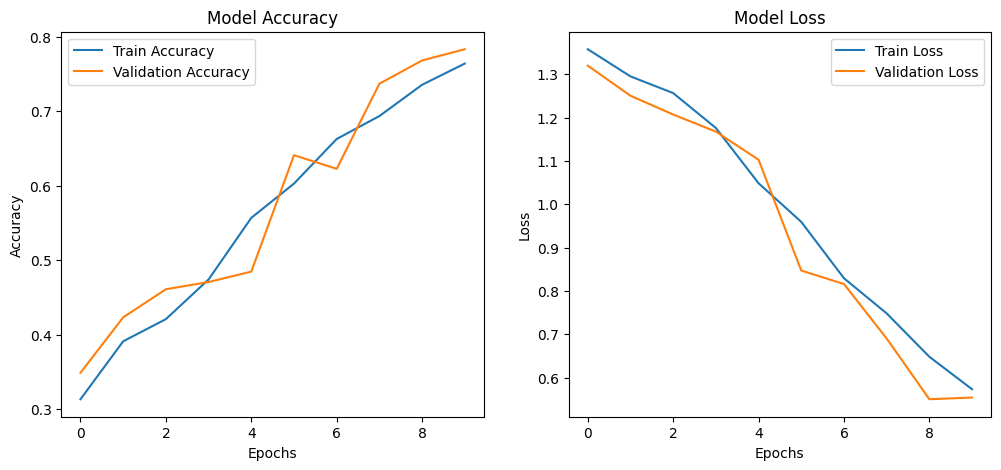

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

plot_training_history(history)

In [12]:
!pip3.12 install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


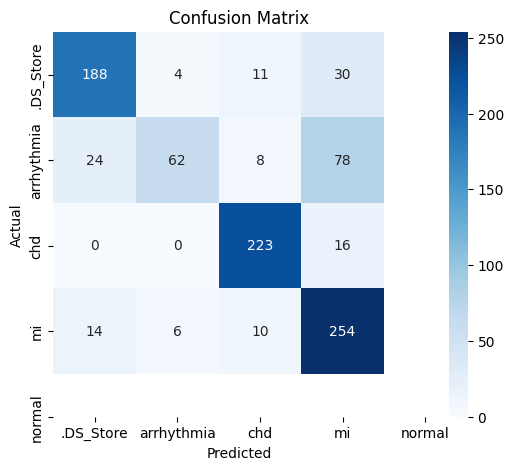

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

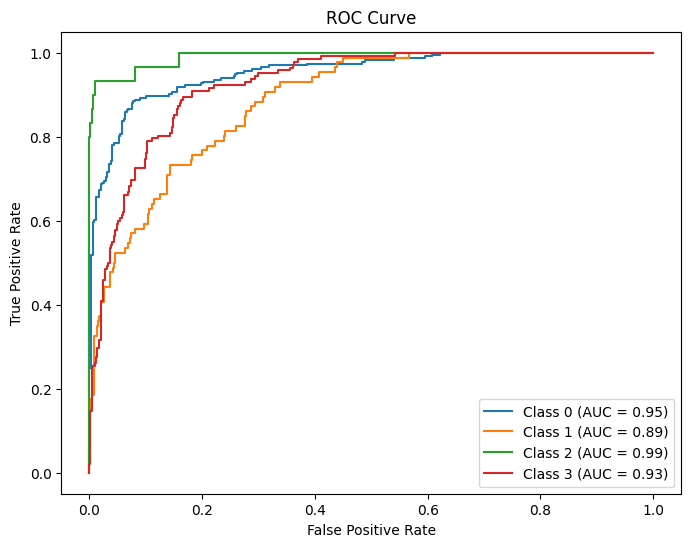

In [15]:
from sklearn.metrics import roc_curve, auc

y_test_bin = to_categorical(y_true_classes, num_classes=num_classes)
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_705']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


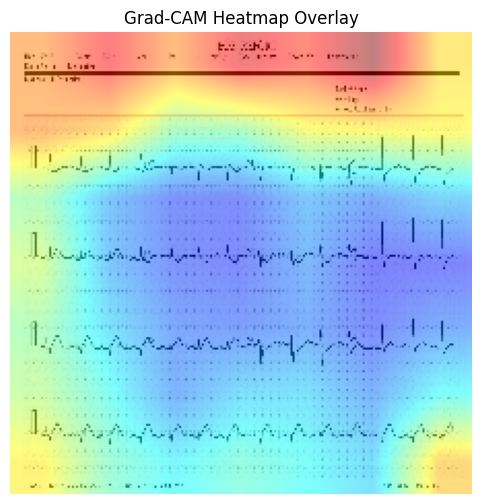

In [21]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image

# Load ResNet50 model without the fully connected layers
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

def preprocess_image(img_path, target_size=(224, 224)):
    """Loads and preprocesses an image for ResNet50"""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

def grad_cam_resnet(image_array, layer_name="conv5_block3_out"):
    """Computes Grad-CAM heatmap for a given image"""
    grad_model = tf.keras.models.Model(
        inputs=[resnet_model.input], 
        outputs=[resnet_model.get_layer(layer_name).output, resnet_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = tf.reduce_max(predictions)  # Use the most confident class
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap[0]
  # Extract the first (only) heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.5):
    """Overlays Grad-CAM heatmap on the original image"""
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Heatmap Overlay")
    plt.show()

# Example Usage:
img_path = "/Users/pavithranarul/Desktop/ml/ecg/ECG1/ECG_dataset/test/mi/MI(1).jpg"  # Replace with actual ECG image path
image_array = preprocess_image(img_path)

# Generate Grad-CAM heatmap
heatmap = grad_cam_resnet(image_array, layer_name="conv5_block3_out")

# Overlay heatmap on original image
overlay_heatmap(img_path, heatmap)


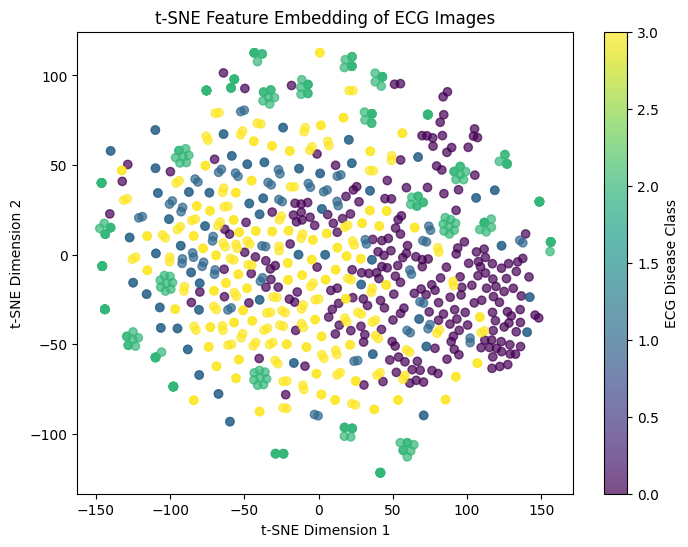

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder


# Assuming X_test_features and y_test are already defined from your dataset
# Reshape features for t-SNE (flatten the last two dimensions)
X_test_reshaped = X_test_features.reshape(X_test_features.shape[0], -1)

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_test_reshaped)

# Decode labels if they are one-hot encoded
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_true_classes, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="ECG Disease Class")
plt.title("t-SNE Feature Embedding of ECG Images")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
